In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm, expon, gamma, skewnorm
import os.path
from sklearn.cluster import AgglomerativeClustering, SpectralBiclustering, SpectralCoclustering, KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import IPython

import sys
sys.setrecursionlimit(10000)

from configMaker import get_model_name

dataset_type = 'processed_imageNet'
model_type = 'logreg_lbfgs'#'all_cnn_c_hidden'
out = '../output-week6'
nametag = 'cluster'#-no-damping'#'cluster'
seeds = [0]
num_train_points = 9000
num_test_points = 3000
num_seeds = len(seeds)
num_classes = 10

test_idx = 1492
test_indices = [2157,2243,1492,684,1246,1225,367,1731,2318,1761]

fontsize=16
sns.set(color_codes=True)
sns.set_style('white')

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

train_f = np.load('../data/animals_900_300_inception_features_train.npz')
train_raw = np.array(train_f['inception_features_val'])
train_labels = np.array(train_f['labels'])
test_f = np.load('../data/animals_900_300_inception_features_test.npz')
test_raw = np.array(test_f['inception_features_val'])
test_labels = np.array(test_f['labels'])

In [10]:
def get_influence_vectors_and_inverse_hvp_and_losses(seed, ignore_hess, test_idx):
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seed)
    f = np.load('../{}/{}_influence_vectors-{}-ignoring-hess-{}.npz'.format(out,model_name,test_idx,ignore_hess))
    f2 = np.load('../{}/{}-cg-normal_loss-test-{}.npz'.format(out,model_name,[test_indices[0]])) ## CHEATING
    f3 = np.load('../{}/{}_train_losses.npz'.format(out, model_name))
    f4 = np.load('../{}/{}_test_losses.npz'.format(out, model_name))
    return f['infl_vectors'], f2['inverse_hvp'], f3['train_losses'], f4['test_losses']

def visualize(ax, idx, group='train'):
    assert group in ['train', 'test']
    #ax.set_aspect('equal')
    if group == 'train':
        ax.plot(train_raw[idx])
        ax.set_title('Train image {} ({})'.format(idx, train_labels[idx]), fontsize=fontsize)
    elif group == 'test':
        ax.plot(test_raw[idx])
        ax.set_title('Test image {} ({})'.format(idx, test_labels[idx]), fontsize=fontsize)

def make_subplots(height, width, sharex=False, sharey=False):
    fig, axs = plt.subplots(height, width, sharex=sharex, sharey=sharey, figsize=(5*width, 5*height))
    return fig, axs

def hist_and_scatter(ax, data, bins=30, alpha=0.3):
    ax.hist(data, bins=bins)
    ax.scatter(data, np.zeros(len(data))-1, alpha=alpha)

def colormesh(ax, data, norm):
    ax.pcolormesh(data,cmap=plt.cm.bwr,norm=norm)

def plot_scatter(ax, data, offset, alpha=0.3):
    #ax.scatter(range(len(data)), np.array(data)+offset, alpha=alpha, s=1)
    ax.plot(np.array(data)+offset)
    
def plot_and_cluster_matrix(data, n_clusters=5, color_scaling=1, n_visualize=3, visualizing=True,\
                            label_pies=True, loss_hist=True, scalar_hist=True):
    norm = colors.Normalize(data.min()/color_scaling,data.max()/color_scaling)
    fig, axs = make_subplots(1, 2)
    colormesh(axs[0], data, norm)
    
    km = KMeans(n_clusters=n_clusters)
    km = km.fit(data)
    labels = km.labels_
    centroids = km.cluster_centers_
    #colormesh(axs[1], centroids, norm)
    for i, cent in enumerate(centroids):
        plot_scatter(axs[1], cent, i*5)
    axs[1].set_ylim(-1,n_clusters*5)
    plt.show()

    if visualizing:
        fig, axs = make_subplots(n_clusters*2, n_visualize)
        for cluster_num in range(n_clusters):
            row = axs[2*cluster_num]
            poss_indices = np.where(labels == [cluster_num] * len(labels))[0]
            row[0].set_ylabel('Cluster {} ({})'.format(cluster_num, len(poss_indices)))
            rand_indices = np.zeros(n_visualize,dtype=np.int)
            for i, ax in enumerate(row):
                rand_indices[i] = np.random.choice(poss_indices)
                visualize(ax, rand_indices[i], 'train')
            row = axs[2*cluster_num+1]
            for i, ax in enumerate(row):
                plot_scatter(ax, centroids[cluster_num], 0)
                plot_scatter(ax, data[rand_indices[i]], 5)
                ax.set_ylim(-1, 7)
                #colormesh(ax, [centroids[cluster_num], data[rand_indices[i]]], norm)
        plt.show()
    
    if label_pies:
        fig, axs = make_subplots(ceil_divide(n_clusters+1, 4), 4)
        for i, row in enumerate(axs):
            for j, ax in enumerate(row):
                cluster_num = len(row) * i + j
                if cluster_num < n_clusters:
                    c = Counter(train_labels[km.labels_ == cluster_num])
                    ax.pie([c[k] for k in range(num_classes)], labels = range(num_classes))
                    ax.set_title('Cluster {} ({})'.format(cluster_num, list(km.labels_).count(cluster_num)))
                elif cluster_num == n_clusters:
                    c = Counter(train_labels)
                    ax.pie([c[k] for k in range(num_classes)], labels = range(num_classes))
                    ax.set_title('All ({})'.format(len(train_labels)))
        plt.show()
    
    if loss_hist:
        fig, axs = make_subplots(ceil_divide(n_clusters+1, 4), 4)
        for i, row in enumerate(axs):
            for j, ax in enumerate(row):
                cluster_num = len(row) * i + j
                if cluster_num < n_clusters:
                    hist_and_scatter(ax, train_losses[km.labels_ == cluster_num])
                    ax.set_title('Cluster {} ({})'.format(cluster_num, list(km.labels_).count(cluster_num)))
                    ax.set_xlabel('Loss')

    if scalar_hist:
        fig, axs = make_subplots(ceil_divide(n_clusters+1, 4), 4)
        for i, row in enumerate(axs):
            for j, ax in enumerate(row):
                cluster_num = len(row) * i + j
                if cluster_num < n_clusters:
                    hist_and_scatter(ax, infl_scalars[km.labels_ == cluster_num])
                    ax.set_title('Cluster {} ({})'.format(cluster_num, list(km.labels_).count(cluster_num)))
                    ax.set_xlabel('Scalar loss influence')
    
    return km
            
infl_vectors_no_hess, inverse_hvp, train_losses, test_losses =\
    get_influence_vectors_and_inverse_hvp_and_losses(seeds[0], True, test_idx)
infl_scalars = np.divide(np.dot(inverse_hvp, np.transpose(infl_vectors_no_hess))[0],num_train_points)
print(infl_vectors_no_hess.shape)

(9000, 20480)


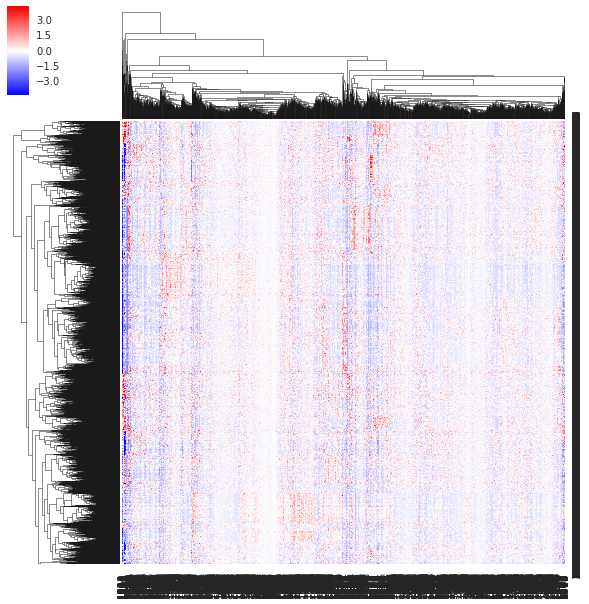

In [3]:
g = sns.clustermap(train_raw,method='complete',cmap='bwr',vmin=train_raw.min()/5,vmax=train_raw.max()/5)

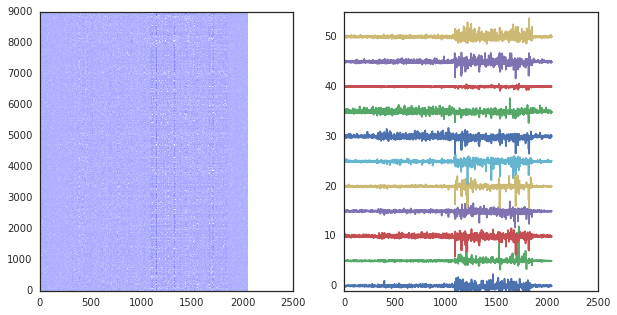

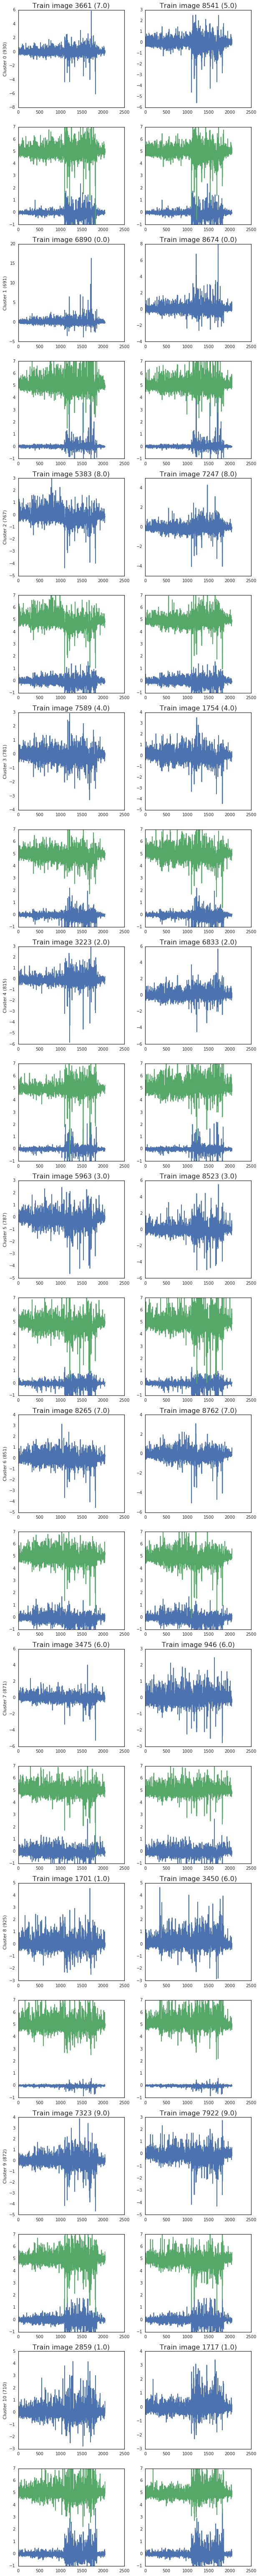

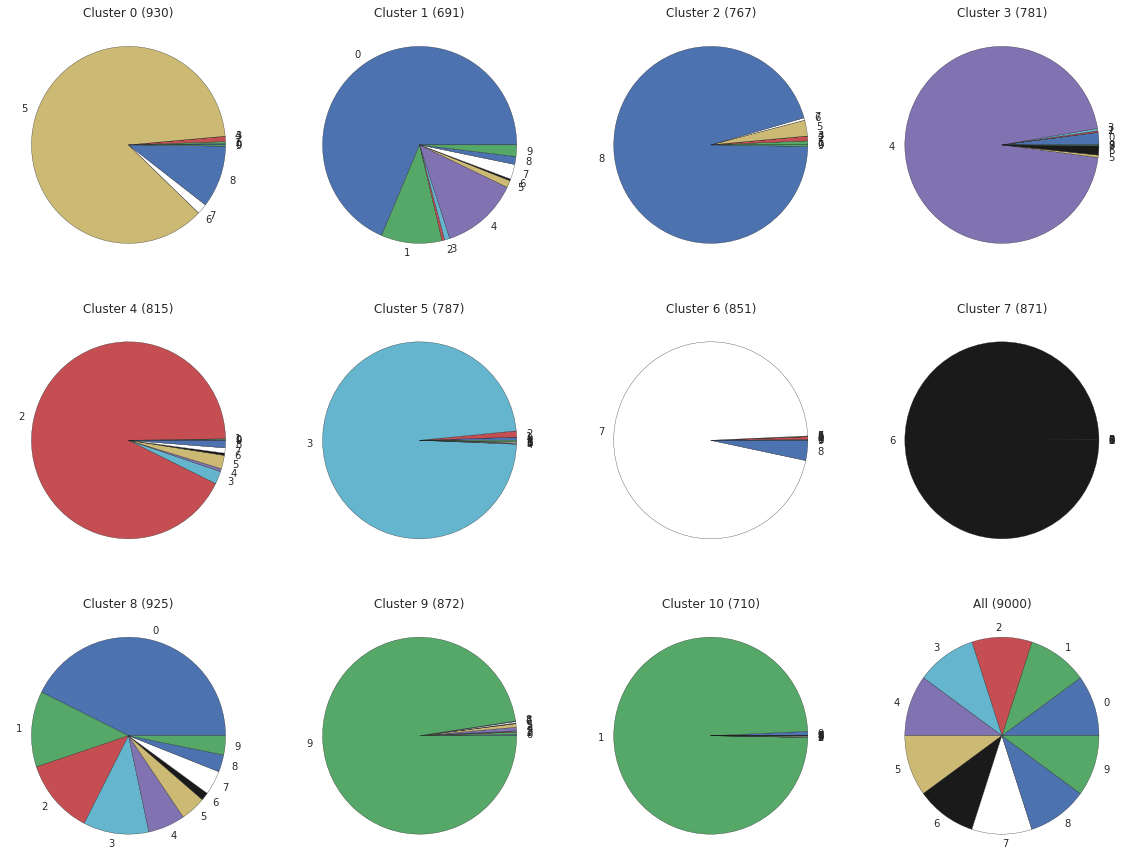

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

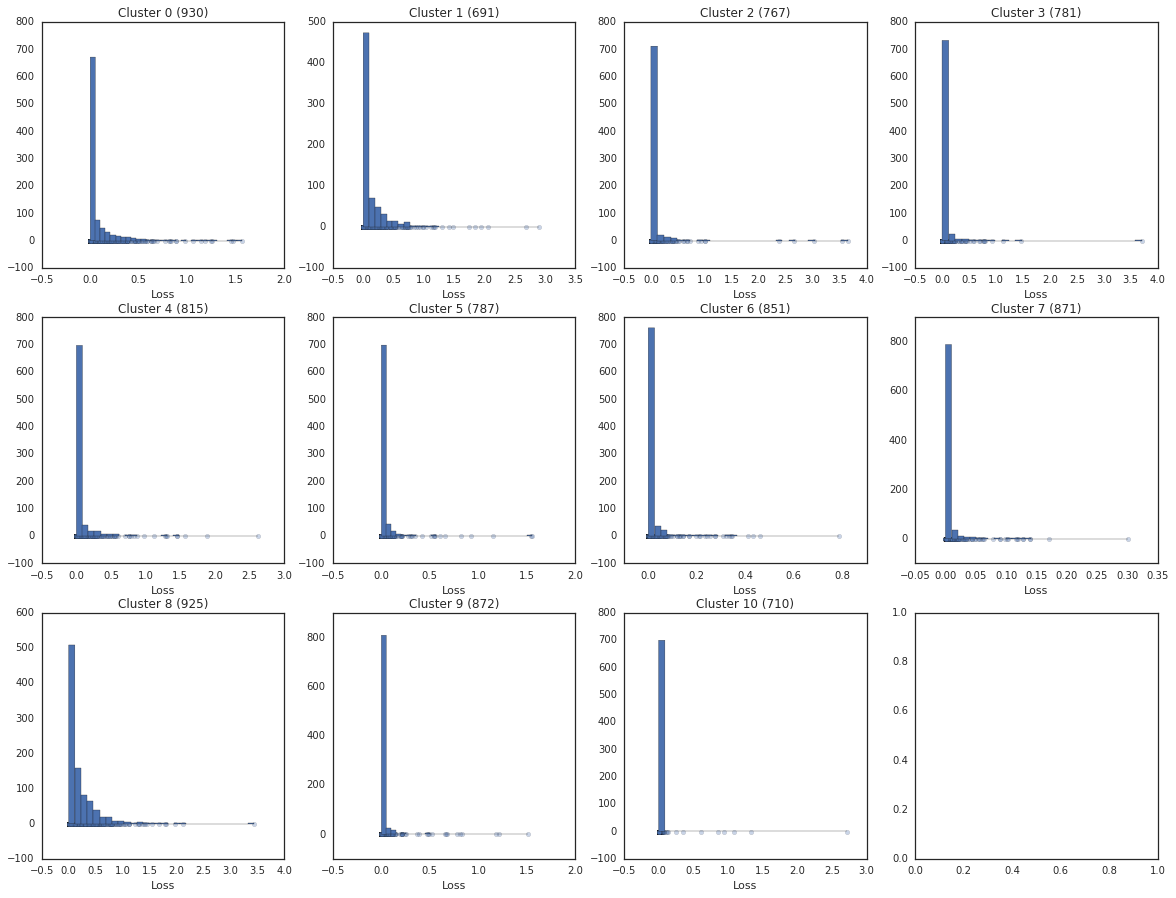

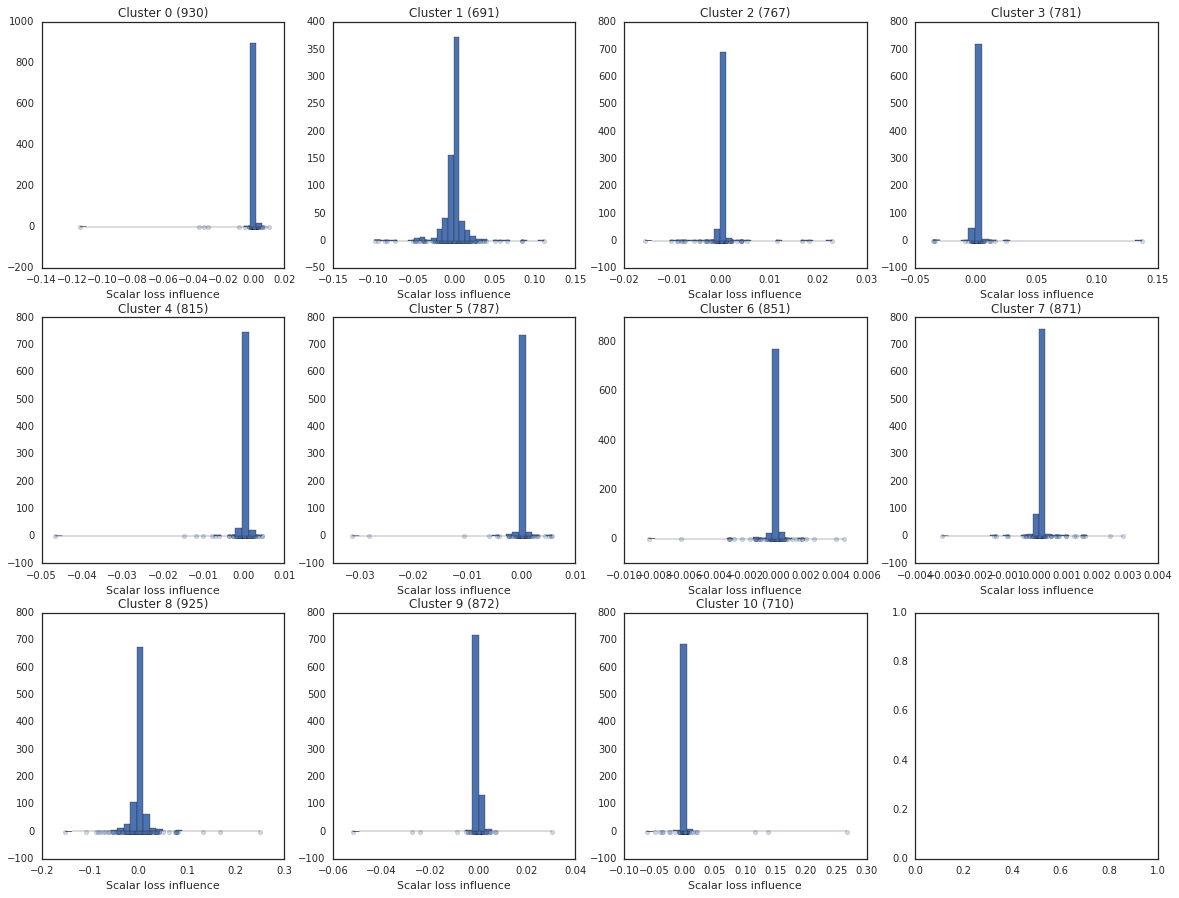

In [11]:
plot_and_cluster_matrix(train_raw, n_clusters=11, n_visualize=2)

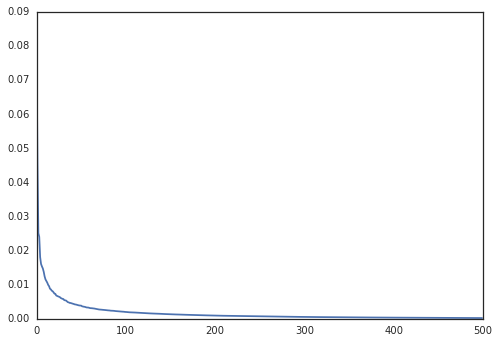

In [5]:
pca = PCA(n_components=500)
infl_vectors_no_hess_lower = pca.fit_transform(infl_vectors_no_hess)
plt.plot(pca.explained_variance_ratio_)
plt.show()

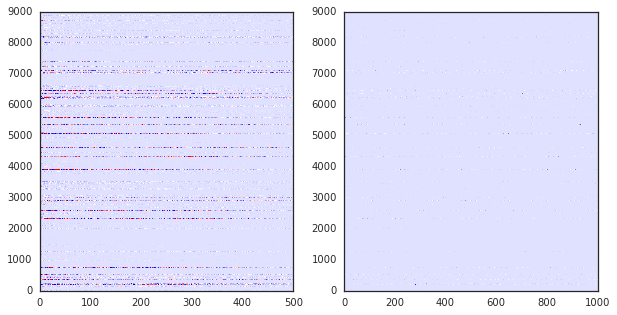

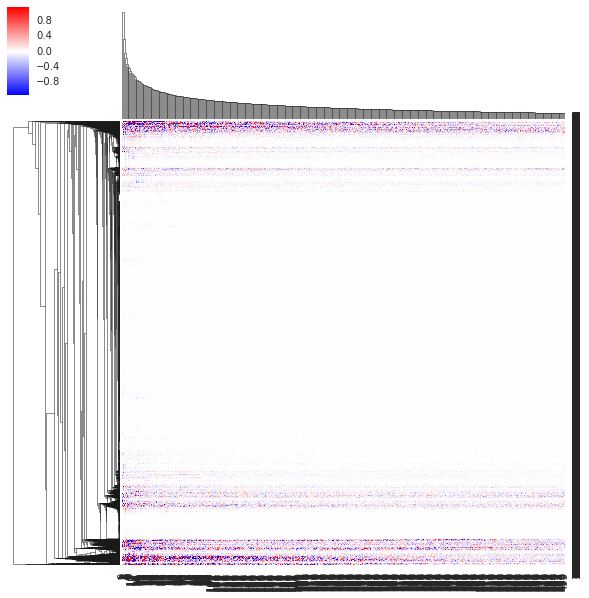

In [6]:
fig, axs = make_subplots(1, 2)
data = infl_vectors_no_hess_lower
color_scaling = 25
norm = colors.Normalize(data.min()/color_scaling,data.max()/color_scaling)
colormesh(axs[0], data, norm)
colormesh(axs[1], infl_vectors_no_hess[:,:1000], norm)
plt.show()

g = sns.clustermap(data,method='complete',cmap='bwr',vmin=data.min()/color_scaling,vmax=data.max()/color_scaling)

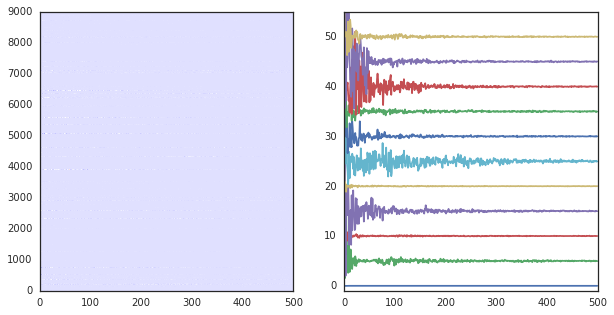

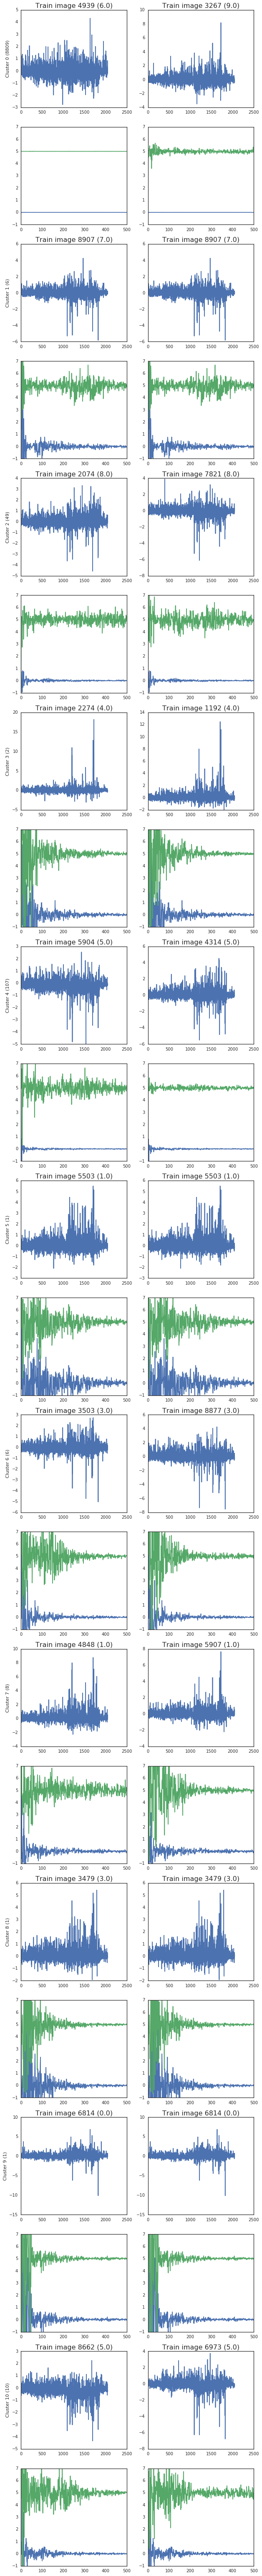

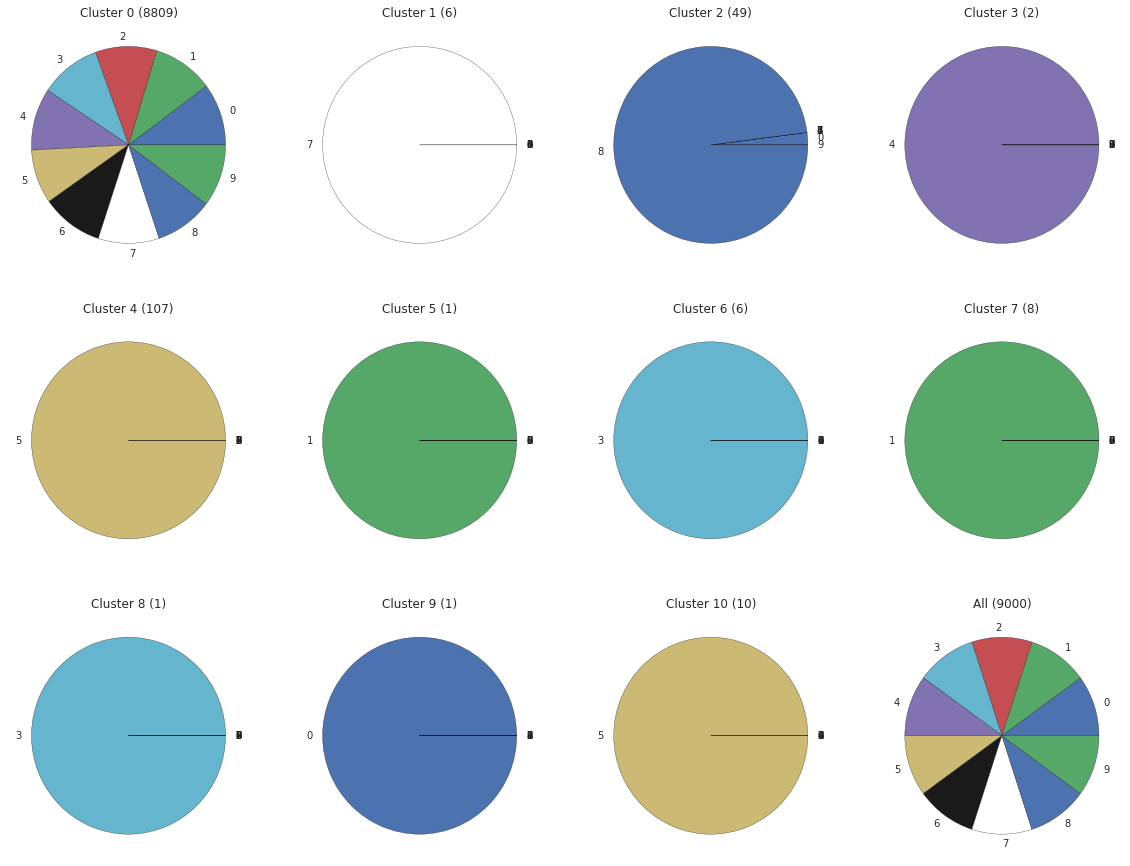

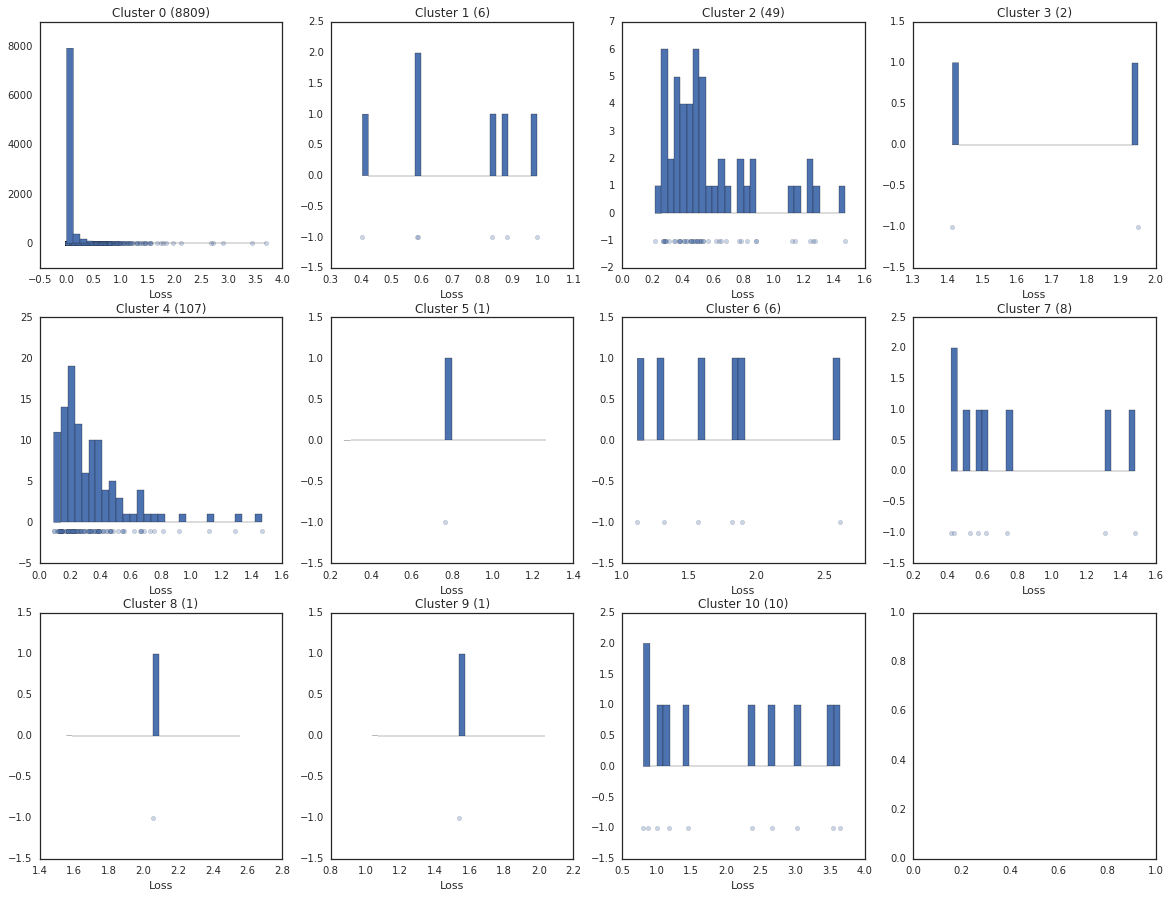

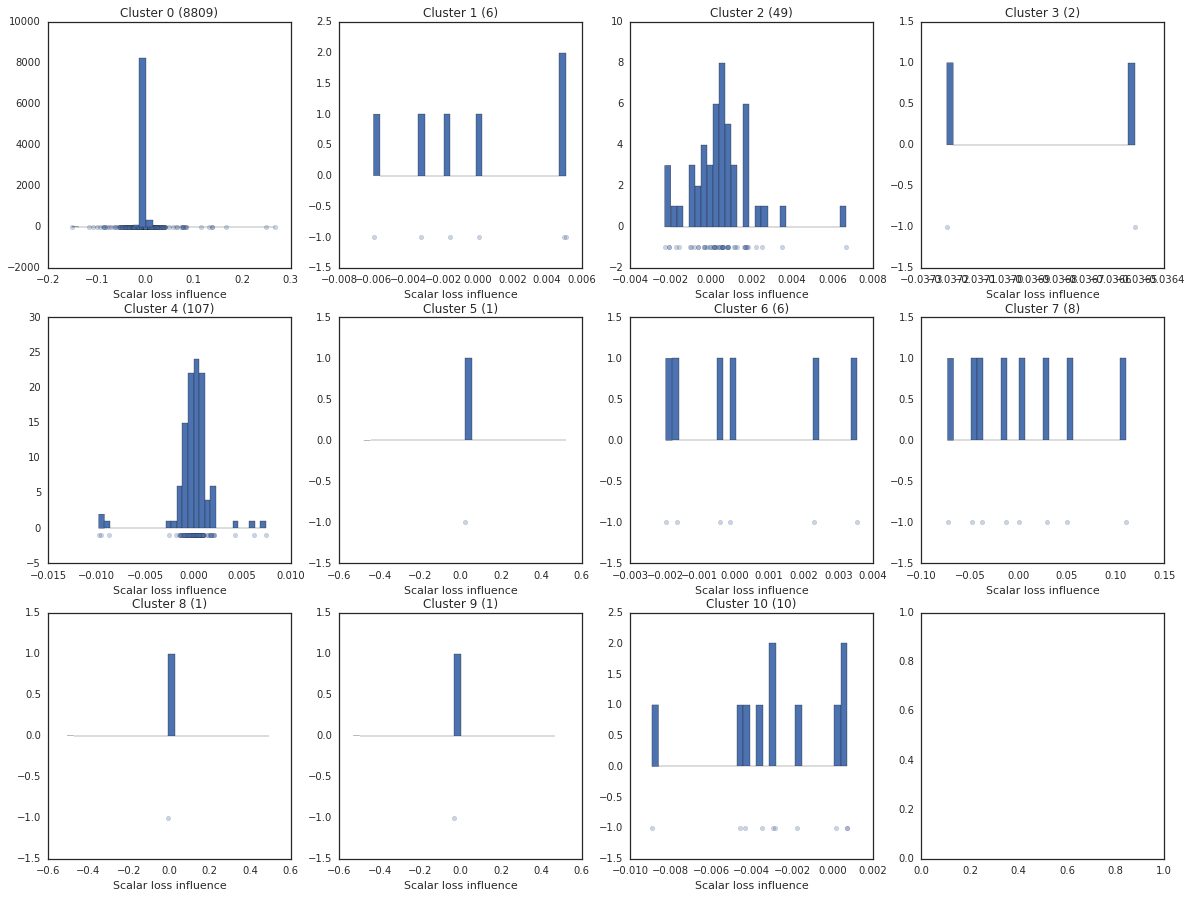

In [14]:
km = plot_and_cluster_matrix(infl_vectors_no_hess_lower, n_clusters=11, n_visualize=2)

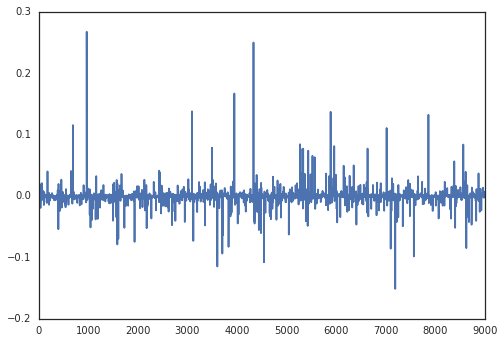

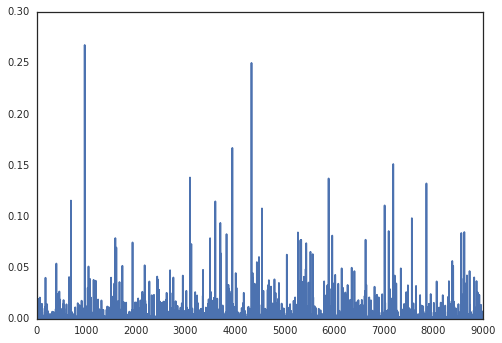

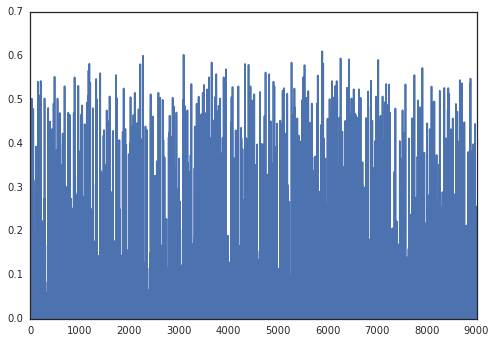

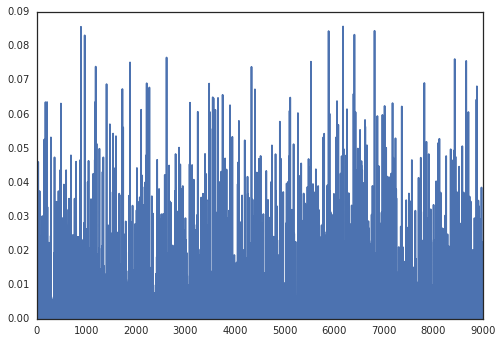

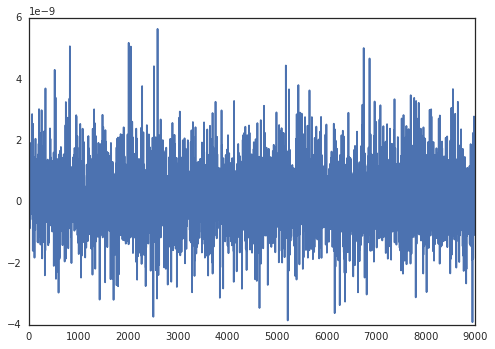

In [7]:
plt.plot(infl_scalars)
plt.show()
plt.plot(np.abs(infl_scalars))
plt.show()
plt.plot(np.mean(np.abs(infl_vectors_no_hess_lower),axis=1))
plt.show()
plt.plot(np.mean(np.abs(infl_vectors_no_hess),axis=1))
plt.show()
plt.plot(np.mean(infl_vectors_no_hess,axis=1))
plt.show()

In [ ]:
# 9000 by 20480 is too much
#km = plot_and_cluster_matrix(infl_vectors_no_hess, n_clusters=11, n_visualize=2, visualizing=True)

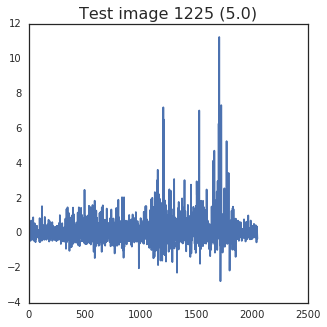

In [15]:
# This is specific to each run of the KMeans, since it's random
fives = np.where(km.labels_ == [4]*num_train_points)
model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seeds[0])
np.savez('../{}/{}_fives_to_remove'.format(out, model_name), fives=fives)
"""model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seeds[0])
f = np.load('../{}/{}_fives_nines_to_remove.npz'.format(out, model_name))
fives, nines = f['fives'], f['nines']
f = np.load('../{}/{}_ordered_influences_on_worst_5_{}.npz'.format(out, model_name, test_indices[5]))
tops = f['indices'][:len(fives[0])]"""
fig, axs = make_subplots(1,1)
visualize(axs,test_indices[5],'test')

In [32]:
#local_test_indices = 'all'
def get_remove_cluster_results(seed, name):
    model_name = get_model_name(nametag=nametag+'retrain', dataset_type=dataset_type, model_type=model_type, seed=seeds[0])
    f = np.load('../{}/{}_before_after_test_losses_vs_influence_on_{}_removing_{}.npz'.format(out, model_name, local_test_indices, name))
    return f['before_test_losses'], f['after_test_losses'], f['influences']

names = ['fives', 'nines', 'top']
befores = [None] * len(names)
afters = [None] * len(names)
influences = [None] * len(names)

for i, name in enumerate(names):
    befores[i], afters[i], influences[i] = get_remove_cluster_results(seeds[0], name)

if local_test_indices == 'all':
    print(afters[0][7859],befores[0][7859],afters[2][7859],befores[2][7859])

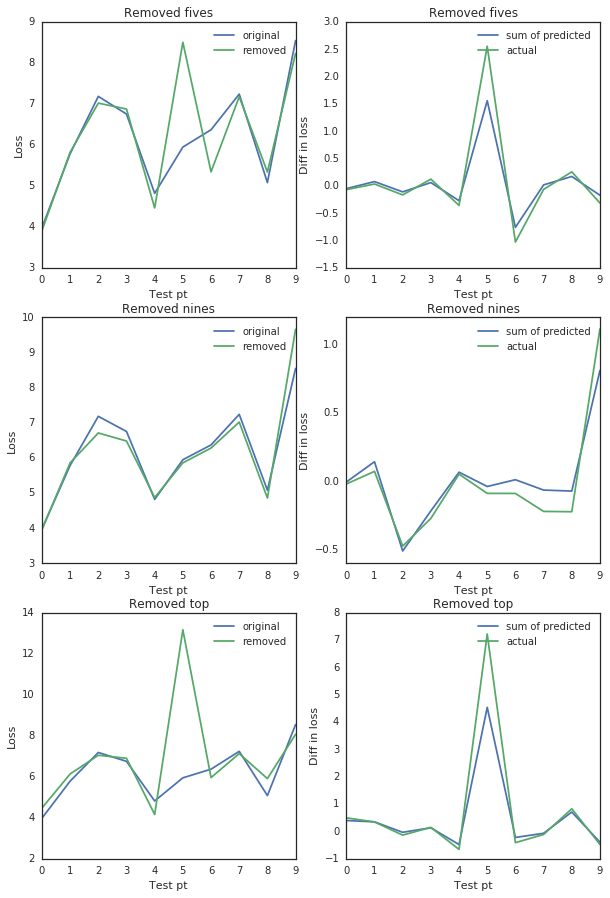

In [35]:
if local_test_indices == 'all':
    fig, axs = make_subplots(len(names)+1,2)
    axs[-1][0].scatter(afters[0],afters[1],alpha=0.2,c=test_labels,cmap='hsv')
    axs[-1][0].set_ylabel('Loss without nines')
    axs[-1][0].set_xlabel('Loss without fives')
    axs[-1][1].scatter(afters[0],afters[2],alpha=0.2,c=test_labels,cmap='hsv')
    axs[-1][1].set_ylabel('Loss without top')
    axs[-1][1].set_xlabel('Loss without fives')
    axs[-1][-1].scatter(range(10),range(10),c=range(10),cmap='hsv')
else:
    fig, axs = make_subplots(len(names),2)
for i, row in enumerate(axs[:len(names)]):
    row[0].plot(befores[i],label='original')
    row[0].plot(afters[i],label='removed')
    row[0].set_ylabel('Loss')
    row[0].set_xlabel('Test pt')
    row[0].set_title('Removed {}'.format(names[i]))
    row[0].legend()
    if local_test_indices == 'all':
        row[1].scatter(befores[i],afters[i],alpha=0.2,c=test_labels,cmap='hsv')
        row[1].set_ylabel('Loss with removed cluster')
        row[1].set_xlabel('Loss with full dataset')
    else:
        row[1].plot(np.sum(influences[i],axis=1),label='sum of predicted')
        row[1].plot(np.subtract(afters[i],befores[i]),label='actual')
        row[1].set_ylabel('Diff in loss')
        row[1].set_xlabel('Test pt')
        row[1].legend()
    row[1].set_title('Removed {}'.format(names[i]))


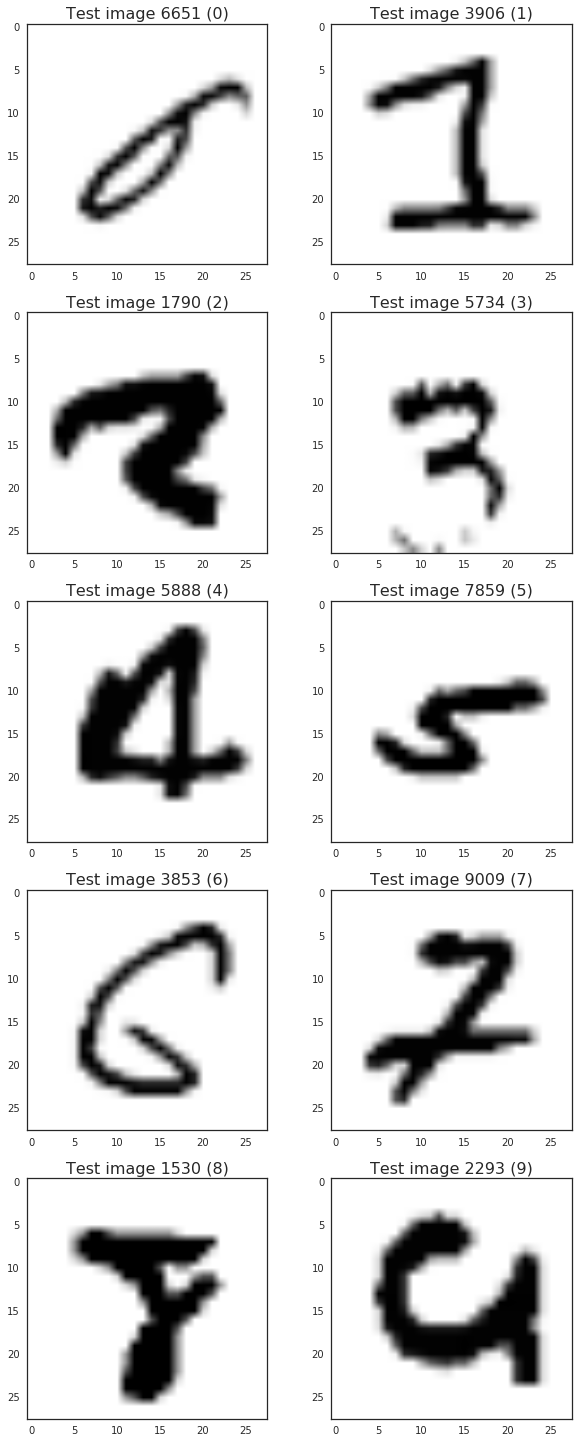

In [31]:
fig, axs = make_subplots(5, 2)
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        num = len(row) * i + j
        visualize(ax, test_indices[num], 'test')

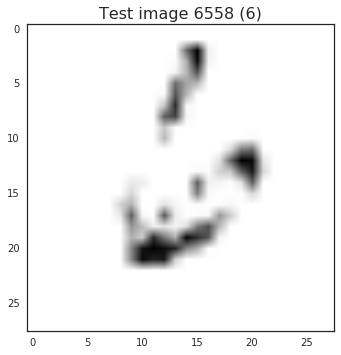

In [4]:
visualize(plt.axes(), test_idx, 'test')